# 22.46 Procesamiento Adaptativo de Señales Aleatorias
# Proyecto 01
## Cancelación Activa de Ruido
Este trabajo desarrolla la síntesis de un sistema de cancelación activa de ruido.

<center><img src="../support/drawing/general_system.png" style='width: 640px;'></center>

#### Grupo N° 1
* DAVIDOV, Gonzalo Joaquín
* FARALL, Facundo David
* KAMMANN, Lucas Agustín
* TROZZO, Rafael Nicolás

In [2]:
import matplotlib.pyplot as plt

In [3]:
from scipy import signal

In [4]:
from scipy import linalg

In [5]:
import numpy as np

In [6]:
import IPython

In [45]:
def plot_anc_results(error_history, weight_history, plot_response=False):
    """ Plot the results of the ANC algorithm.
        @param error_history
        @param weight_history
    """
    fig, ax = plt.subplots(2, 1, figsize=(18, 18))
    
    ax[0].plot(error_history)
    ax[0].set_ylabel('$e(n)$', fontsize=16)
    ax[0].set_xlabel('$n$', fontsize=16)
    ax[0].grid()
    
    if plot_response:
        ax[1].stem(weight_history[-1,:])
        ax[1].set_ylabel('$w_n$', fontsize=16)
        ax[1].set_xlabel('$n$', fontsize=16)
        ax[1].grid()
    else:
        for i in range(weight_history.shape[0]):
            ax[1].plot(weight_history[i,:])
        ax[1].set_ylabel('$w_i(n)$', fontsize=16)
        ax[1].set_xlabel('$n$', fontsize=16)
        ax[1].grid()
    
    plt.show()

# 1. Introducción
El esquema ilustrado permite describir el comportamiento real en un sistema acústico, como son auriculares. Para la validación del comportamiento del sistema propuesto, se utilizarán bases de datos con mediciones realizadas sobre sistemas físicos reales, para simular su respuesta y operar el cancelador activo de ruido sobre ella.


<table>
    <tr>
        <td><center><img src="../support/drawing/headphone_system.png" style='width: 480px;'></center></td>
        <td><center><img src="../support/drawing/headphone_paths.png" style='width: 500px;'></center></td>
    </tr>
</table>


## 1.1. Selección de señal de ruido
En esta sección, se selecciona la señal de ruido $x(n)$ que se utilizará para simular condiciones en un ambiente ruidoso, y se estudian sus aspectos característicos.

In [38]:
# Create noise samples to stimulate the acoustic system and
# validate whether the active noise cancelling system is working
fs = 48000                        # Sampling frequency
tt = 1                            # Total time of simulation
dtt = int(fs * tt)                # Discrete total time of simuluation
x = np.random.normal(size=dtt)

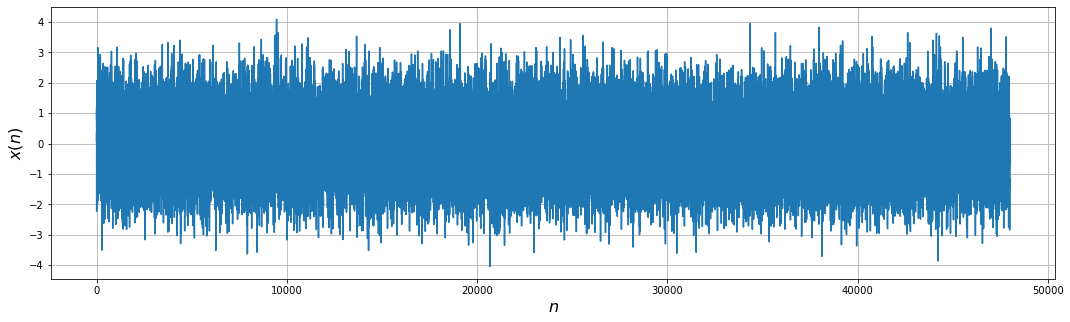

In [39]:
# Plot the input noise
plt.figure(figsize=(18, 5))
plt.plot(x)
plt.ylabel('$x(n)$', fontsize=16)
plt.xlabel('$n$', fontsize=16)
plt.grid()
plt.show()

In [40]:
# Listen the noise
IPython.display.Audio(x, rate=fs)

## 1.2. Simulación del sistema acústico
En esta sección, se construye un modelo matemático para simular el comportamiento del sistema acústico sobre el cual se desea aplicar la cancelación activa de ruido.

In [11]:
import json

In [12]:
class AcousticModel:
    """ The AcousticModel class exposes an inteface to simulate the interaction
        with the physical system. This allows us to encapsulate the physical model
        to easily simulate it while developing the active noise cancelling system.
    """
    
    def __init__(self):
        raise NotImplemented
    
    def __len__(self):
        """ Returns the length of the acoustic model, understood as the amount
            of samples for simulation that it contains.
        """
        raise NotImplemented
    
    def set_noise(self, x):
        """ Set the noise samples
            @param x Array containing noise samples for the acoustic simulation
        """
        raise NotImplemented

    def reference_microphone(self):
        """ Takes a sample from the reference microphone.
            @return Reference signal sample
        """
        raise NotImplemented
    
    def error_microphone(self):
        """ Takes a sample from the error microphone.
            @return Error signal sample
        """
        raise NotImplemented
    
    def speaker(self, y):
        """ Sets the output sample for the speaker.
            @param y Output signal sample
        """
        raise NotImplemented
    
    def step(self):
        """ Moves forward to the next sampling time or instant.
            @return Boolean indicating it has not reached the end of the samples
        """
        raise NotImplemented
    
    def reset(self):
        """ Resets the sampling time to zero.
        """
        raise NotImplemented

In [22]:
class BoseQC20(AcousticModel):
    """ Acoustic simulation of the BoseQC20 headphones based on the measurements
        performed by 
            'Acoust path database for ANC in-ear headphone development'
            Stefan LIEABICH, Johannes FABRY, Peter JAX, Peter VARY

        NOTE: It only supports simulating the primary acoustic path
    """
    
    def __init__(self, filepath):
        """ Initializes the BoseQC20 instance
            @param filepath Filepath to the JSON file containing the dataset
        """
        
        # Open the JSON file containing measurements of the BoseQC20 headphones
        self.acoustic_paths_filepath = filepath
        self.acoustic_paths_file = open(self.acoustic_paths_filepath, 'r')
        self.acoustic_paths_data = json.load(self.acoustic_paths_file)
        
        # Choose the physical or acoustic paths from the dataset
        self.p = self.acoustic_paths_data['anechoic_chamber']['primary'][0][0]          # Primary acoustic path impulse response estimation
        self.g = self.acoustic_paths_data['anechoic_chamber']['secondary'][0]           # Secondary acoustic path impulse response estimation
        self.f = self.acoustic_paths_data['anechoic_chamber']['feedback'][0]            # Feedback acoustic path impulse response estimation
        
        # Initialize internal signals
        self.x = None                                                              # Input signal of the acoustic model for simulation
        self.y = None                                                              # Saves the speaker sample
        self.n = -1                                                                # Current sampling time or instant                                            
    
    def __len__(self):
        """ Returns the length of the acoustic model, understood as the amount
            of samples for simulation that it contains.
        """
        return len(self.x)
    
    def set_noise(self, x):
        """ Set the noise samples
            @param x Array containing noise samples for the acoustic simulation
        """
        # Set the noise samples
        self.x = x
        
        # Calculate the response of the primary acoustic path
        self.d = signal.lfilter(self.p, [1.0], self.x)

    def reference_microphone(self):
        """ Takes a sample from the reference microphone.
            @return Reference signal sample
        """
        return self.x[self.n]
    
    def error_microphone(self):
        """ Takes a sample from the error microphone.
            @return Error signal sample
        """
        return self.d[self.n] + self.y
    
    def speaker(self, y):
        """ Sets the output sample for the speaker.
            @param y Output signal sample
        """
        self.y = y
    
    def step(self):
        """ Moves forward to the next sampling time or instant.
            @return Boolean indicating it has not reached the end of the samples
        """
        if self.n < len(self.x) - 1:
            self.n += 1
            return True
        else:
            return False
    
    def reset(self):
        """ Resets the sampling time to zero.
        """
        self.n = -1

In [23]:
class Primary(AcousticModel):
    """ Acoustic model of the primary path.
    """
    
    def __init__(self):
        self.x = None                                       # Input signal of the acoustic model
        self.y = None                                       # Buffering for the secondary acoustic path
        self.n = -1                                         # Current sampling time or instant
    
    def __len__(self):
        """ Returns the length of the acoustic model, understood as the amount
            of samples for simulation that it contains.
        """
        return len(self.x)
    
    def set_noise(self, x):
        """ Set the noise samples
            @param x Array containing noise samples for the acoustic simulation
        """
        # Set the noise samples
        self.x = x
        
        # Calculate the response of the primary acoustic path
        self.d = signal.lfilter(np.ones(10) / 10, [1.0], x) # Response of the primary acoustic path

    def reference_microphone(self):
        """ Takes a sample from the reference microphone.
            @return Reference signal sample
        """
        return self.x[self.n]
    
    def error_microphone(self):
        """ Takes a sample from the error microphone.
            @return Error signal sample
        """
        return self.d[self.n] + self.y
    
    def speaker(self, y):
        """ Sets the output sample for the speaker.
            @param y Output signal sample
        """
        self.y = y
    
    def step(self):
        """ Moves forward to the next sampling time or instant.
            @return Boolean indicating it has not reached the end of the samples
        """
        if self.n < len(self.x) - 1:
            self.n += 1
            return True
        else:
            return False
    
    def reset(self):
        """ Resets the sampling time to zero.
        """
        self.n = -1

# 2. Modelado del camino acústico primario $P(z)$
En esta sección, se propone una primera iteración del sistema para modelar el camino acústico primario.

<table>
    <tr>
        <td><center><img src="../support/drawing/scheme_iteration_01.png" style='width: 480px;'></center></td>
        <td><center><img src="../support/drawing/algorithm_iteration_01.png" style='width: 600px;'></center></td>
    </tr>
</table>

In [24]:
import time

In [25]:
def anc_montecarlo(iterations, model, anc, size, order, step):
    """ Run a montecarlo simulation for the ANC system provided.
        @param iterations Amount of iterations for the simulation
        @param model Instance of an AcousticModel
        @param anc Function that executes the active noise cancelling
        @param size Amount of samples for iteration
        @param order Order of the FIR for the adaptive filter
        @param step Step size for LMS based algorithm
        @return Error and coefficients evolution for each iteration
    """
    
    # Create an instance of the acoustic model to be used
    # and generate a sample function of the input noise x(n)
    # to run the simulation. We are using white gaussian noise.
    noise = np.random.normal(size=size)
    model.set_noise(noise)
    
    # Initialize arrays used to register the error and coefficients
    # to be averaged and plotted at the end of the montecarlo simulation
    e = np.zeros((iterations, size))
    w = np.zeros((iterations, order, size))
    
    # Run each simulation
    for i in range(iterations):
        print(f'Running simulation {i + 1} of {iterations}')
        start_time = time.time()
        e_i, w_i = anc(model, order, step)
        end_time = time.time()
        e[i,:] = e_i
        w[i,:,:] = w_i
        model.reset()
        print(f'Finished in {np.round(end_time - start_time, 5)} s')
    
    # Return simulation results
    return e, w

In [26]:
def anc_primary(model, order, step):
    """ Active Noise Cancelling
        Apply the active noise cancelling algorithm to compensate the
        noise by modeling the primary acoustic path.
        
        @param model Instance of an acoustic model for simulation
        @param order Order of the filter
        @param step Step size used for LMS
        @return Tuple containing the error signal and the coefficients evolution
                (error_signal, coefficients_evolution)
    """
    # Validate metaparameters
    if type(order) is int:
        if order < 1:
            raise ValueError("The minimum order is 1")
    else:
        raise ValueError("Order argument must be integer")
    if step <= 0:
        raise ValueError("The step size must be a positive value")
        
    # Parameters
    N = len(model)
    
    # Initialize arrays
    r = np.zeros(order)
    w = np.zeros(order)
    e_n = np.zeros(N)
    w_n = np.zeros((order, N))
    i = 0
    
    # Sample processing loop
    while (model.step()):
        # Take a new input sample and update the input buffer of the digital filter
        # by rolling the numpy array one place and introducing the new sample
        r = np.roll(r, 1)
        r[0] = model.reference_microphone()

        # Compute the output sample
        y = -np.dot(w, r)
        model.speaker(y)

        # Take a new error sample
        e = model.error_microphone()

        # Update the digital filter coefficients
        w += step * r * e

        # Save history
        e_n[i] = e
        w_n[:,i] = w
        i += 1
    
    return e_n, w_n

In [51]:
headphone = BoseQC20('../samples/BoseQC20.json')
headphone.set_noise(x)
it1_e, it1_w = anc_primary(headphone, order=2000, step=0.0001)

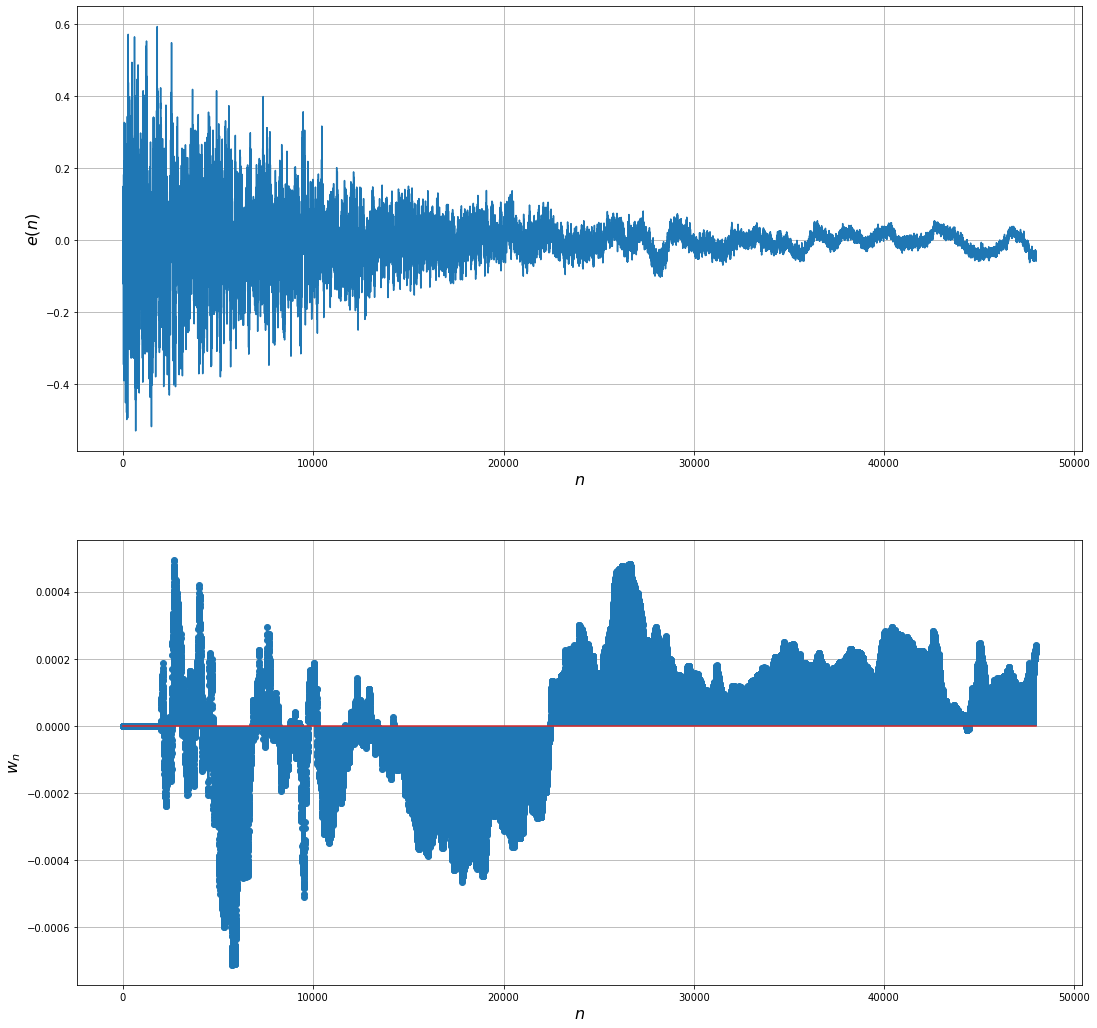

In [52]:
plot_anc_results(it1_e, it1_w, plot_response=True)

In [53]:
IPython.display.Audio(it1_e, rate=fs)

## 3. Compensando el camino acústico secundario $G(z)$
En esta sección, se propone una segunda iteración del sistema para compensar el camino acústico secundario.

<table>
    <tr>
        <td><center><img src="../support/drawing/scheme_iteration_02.png" style='width: 480px;'></center></td>
        <td><center><img src="../support/drawing/algorithm_iteration_02.png" style='width: 600px;'></center></td>
    </tr>
</table>

In [16]:
def anc_primary_secondary(model, order, step):
    """ Active Noise Cancelling
        Apply the active noise cancelling algorithm to compensate the
        noise by modeling the primary acoustic path and compensating the 
        secondary acoustic path.
        
        @param model Instance of an acoustic model for simulation
        @param order Order of the filter
        @param step Step size used for LMS
        @return Tuple containing error and coefficients of each iteration of the LMS algorithm
                (error_history, weight_history)
    """
    # Validate metaparameters
    if type(order) is int:
        if order < 1:
            raise ValueError("The minimum order is 1")
    else:
        raise ValueError("Order argument must be integer")
    if step <= 0:
        raise ValueError("The step size must be a positive value")
        
    # Parameters
    N = len(model)
    
    # Initialize arrays
    r = np.zeros(order)
    rg = np.zeros(order)
    w = np.zeros(order)
    e_history = np.zeros(N)
    w_history = np.zeros((order, N))
    i = 0
    
    # TODO: Don't hardcode, but identify the system, of G(z)
    g = np.zeros(order)
    g[4] = 1
    
    # Sample processing loop
    while (model.step()):
        # Take a new input sample and update the input buffer of the digital filter
        # by rolling the numpy array one place and introducing the new sample
        r = np.roll(r, 1)
        r[0] = model.reference_microphone()

        # Compute the output sample
        y = -np.dot(w, r)
        model.speaker(y)

        # Take a new error sample
        e = model.error_microphone()
        
        # Filter with G(z)
        rg = np.roll(rg, 1)
        rg[0] = np.dot(g, r)

        # Update the digital filter coefficients
        w += step * rg * e

        # Save history
        e_history[i] = e
        w_history[:,i] = w
        i += 1
    
    return e_history, w_history

In [17]:
it2_error_history, it2_weight_history = anc_primary_secondary(PrimaryAndSecondary(x), order=15, step=0.00001)

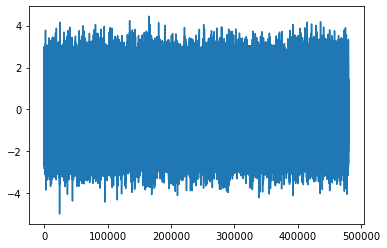

In [18]:
plt.plot(x)

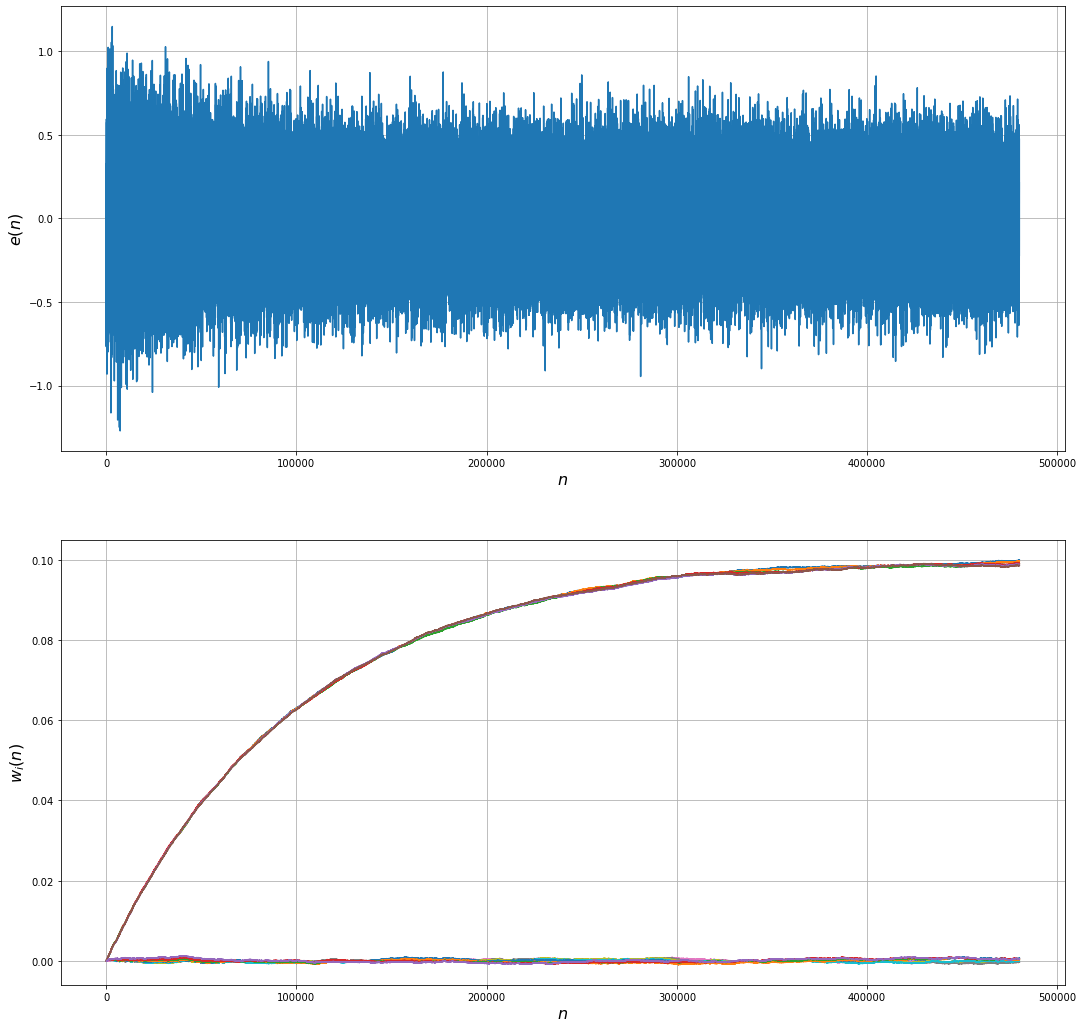

In [19]:
plot_anc_results(it2_error_history, it2_weight_history)

In [20]:
it2_error_history.var()

0.04632197725466491

In [21]:
x.var()

0.998671706422137

In [22]:
it2_weight_history[:,-1]

array([ 9.99079905e-02,  9.97566900e-02,  9.90856910e-02,  9.91528870e-02,
        9.88759834e-02,  9.85999857e-02, -2.96655561e-04, -2.88560511e-04,
        4.09071445e-05,  1.05213652e-06,  6.37461521e-04,  3.33341675e-04,
        4.83998353e-04,  4.63166189e-04,  4.31783263e-04])

In [23]:
IPython.display.Audio(it2_error_history, rate=fs)